In [1]:
#import relevant packages for analysis

from __future__ import print_function

import os
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np
import pandas as pd


from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, Slider, Select, NumeralTickFormatter, Span
from bokeh.palettes import Spectral8
from bokeh.layouts import column, widgetbox, row

from bokeh.transform import dodge
from bokeh.core.properties import value
from bokeh.models.tickers import FixedTicker

output_notebook()


sns.set(rc = {'figure.figsize' : (11, 4)})

PROJ_ROOT = os.path.join(os.pardir)

Loading BokehJS ...

In [2]:
%load_ext watermark
%watermark -a "Bryan Dickinson" -d -t -v -p numpy,pandas

Bryan Dickinson 2019-08-15 11:55:18 

CPython 3.7.3
IPython 7.7.0

numpy 1.16.4
pandas 0.25.0


In [3]:
#Create the path to the data and read into a pandas dataframe

terry_data = os.path.join(PROJ_ROOT, 
                         'data', 'processed',
                         'Terry_Stops_Clean.csv')

data = pd.read_csv(terry_data, parse_dates = ['date'], 
                   index_col = 'date', dtype = {'officer_race':'category','officer_gender':'category',
                                                'subject_age':'category',
                                                'subject_race':'category','subject_gender': 'category',
                                                'stop_resolution': 'category','weapon_type':'category',
                                                'call_type':'category','arrest':'int32', 'frisk':'float',
                                                'precinct':'category', 'sector':'category', 'beat': 'category'})

data.sort_index(inplace = True)

data['count'] = 1

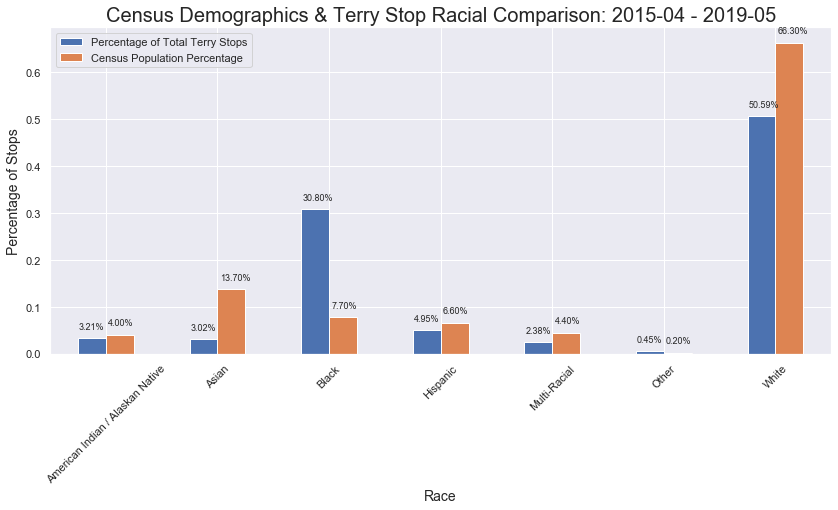

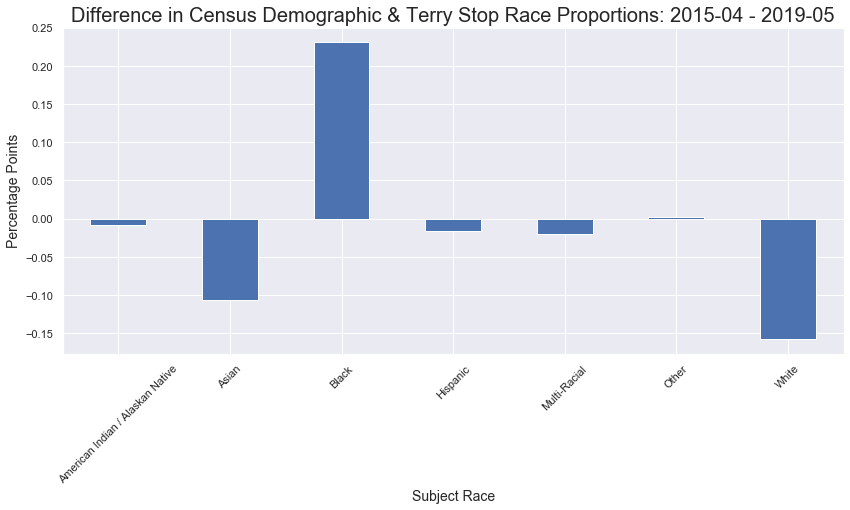

In [4]:

tmp = data[['subject_race','count']]
tmp = tmp.groupby('subject_race').count()
tmp['stop_pct'] = tmp['count'] / tmp['count'].sum()
tmp.drop(['count'], axis = 1, inplace = True)

#create dataframe with census data information & join with main information
census_data = pd.DataFrame(index = tmp.index, data = {'census_pct' : [.04,.137,.077,.066,.044,.002,np.nan,.663,]} )
tmp = tmp.join(census_data)
tmp = tmp[tmp.index != 'Unknown']


#plot the data
ax = tmp.plot(kind = 'bar', figsize = (14,6))

#display the values over the corresoponding bar graphs
for i, v in enumerate(tmp.stop_pct):
    ax.text(i-.24, v+.02, '{:.2f}%'.format(100*v),fontsize = 9 )

for i, v in enumerate(tmp.census_pct):
    ax.text(i+.02, v+.02, '{:.2f}%'.format(100*v),fontsize = 9 )
    
    


_=plt.xticks(rotation = 45)
_=plt.title('Census Demographics & Terry Stop Racial Comparison: 2015-04 - 2019-05', fontsize = 20)
_=plt.xlabel('Race', fontsize = 14)
_=plt.ylabel('Percentage of Stops', fontsize = 14)
_=plt.legend(loc = 'best', labels = ['Percentage of Total Terry Stops', 'Census Population Percentage'] )
plt.show()



tmp['diff'] = tmp.stop_pct - tmp.census_pct
tmp['diff'].plot(kind = 'bar', figsize = (14,6))
_=plt.xlabel('Subject Race', fontsize = 14)
_=plt.ylabel('Percentage Points', fontsize = 14)
_=plt.title('Difference in Census Demographic & Terry Stop Race Proportions: 2015-04 - 2019-05', fontsize = 20)
_=plt.xticks(rotation = 45)
plt.show()


We see that between 2015 - 2019 Black people account for 31% of total Terry Stops.  When compared to the the 2010 census population data, all groups with the exception of 'Other' and Blacks are stopped at lesser percentage point than the population. Blacks are stopped 300 times more than what the 2010 census population stated.

**Conclusion**  
There appears to be a larger proportion of black residents stopped compared to the census population proportions. Conversly there is a smaller proportion of white and asian residents stopped compared to the censur population proportions.

There appears to be a significantly larger percentage of Terry Stops of Black residents over the population make up of the area compared to other races.

The below graphic shows the trend of each subject race over time.

In [5]:

tmp = data[['subject_race','count']]
tmp = tmp['count'].resample('M').count()

date_range = pd.date_range(start = tmp.index[0], end = tmp.index[-1], freq = 'M')


census_data = pd.DataFrame(index = ['American Indian / Alaskan Native', 'Asian','Black',
                                            'Hispanic','Multi-Racial','Other','White'],
                           data = {'census_pct' : [.04,.137,.077,.066,.044,.002,.663,]})

dff = pd.DataFrame()

for date in date_range:
    tmp = data[['subject_race','count']]
    tmp = tmp.loc[str(date.year)+'-'+str(date.month)]
   
    tmp = tmp.groupby('subject_race').count()
    tmp = pd.concat([tmp, census_data], axis = 1)
    tmp = tmp[tmp.index != 'Unknown']
    tmp['date'] = date
    tmp['stop_pct'] = tmp['count'] / tmp['count'].sum()
    tmp['difference'] = tmp['stop_pct'] - tmp['census_pct']
    dff = dff.append(tmp)

dff.drop(['count'], axis = 1, inplace = True)


In [6]:

def modify_doc(doc):
    dts = [str(datetime.utcfromtimestamp(x.astype(datetime)/1e9).year)+'-'+str(datetime.utcfromtimestamp(x.astype(datetime)/1e9).month) for x in list(dff.date.unique())] 
    dates = pd.to_datetime(dff.date.unique())
    source = ColumnDataSource(data = {'x' : dates,
                                  'y' : dff.loc['White'].difference,
                                 'census_pct' : dff.loc['White'].census_pct,
                                 'stop_pct' : dff.loc['White'].stop_pct,
                                 'difference' : dff.loc['White'].difference,
                                     'legend' : dff.loc['White'].index,
                                      'date':dff.loc['White'].date}
                                )
    ymin, ymax = min(dff.difference), (max(dff.difference)+.1)
    
    hover = HoverTool(tooltips = [('Subject Race', '@legend'),
                                  ('Difference', '@{difference}{0:+.02%}'),
                                  ('Census Pct', '@{census_pct}{0:.02%}'),
                                  ('Percentage of Stops', '@{stop_pct}{0:.02%}'),
                                 ('Date', '@date{%Y-%m}')],
                      formatters={'date': 'datetime'},
                      mode = 'vline')
    
    
    plot = figure(title = '{} Difference in Terry Stop Race Proportions & Census Demographic'.format('White'), plot_height = 300,
                 plot_width = 850, x_axis_type='datetime', y_range = (ymin, ymax), tools = [hover])
    
    plot.circle(x = 'x', y='y', size = 7, fill_color = 'grey', source = source, 
                alpha=.1, line_color = None, 
                hover_fill_color = 'lawngreen', hover_alpha = .9, hover_line_color = 'white')
    
    plot.line(x = 'x', y = 'y', source = source, line_width = 2, legend = 'legend')
    
    span = Span(location = 0, line_dash = 'dashed', line_alpha = .5, line_color = 'green')
    plot.add_layout(span)
    
    y_select = Select(options = list(dff.index.unique()), value = 'White', title = 'Subject Race' )
    
    plot.yaxis[0].formatter = NumeralTickFormatter(format = '0.0%')

    
    def update_plot(attr, old, new):
        y = y_select.value
        
        new_data = {'x' : dates,
                    'y' : dff.loc[y].difference,
                    'census_pct' : dff.loc[y].census_pct,
                    'stop_pct' : dff.loc[y].stop_pct,
                    'difference' : dff.loc[y].difference,
                    'legend' : dff.loc[y].index,
                    'date' : dff.loc[y].date
        }
        source.data = new_data
        
        plot.title.text = '{} Race Difference in Terry Stop Proportions & Census Demographic'.format(y)
    
    y_select.on_change('value', update_plot)
    
    doc.add_root(column(y_select, plot))

In [7]:
show(modify_doc)

### Is there a difference in racial comparison of stops by race of the officer?

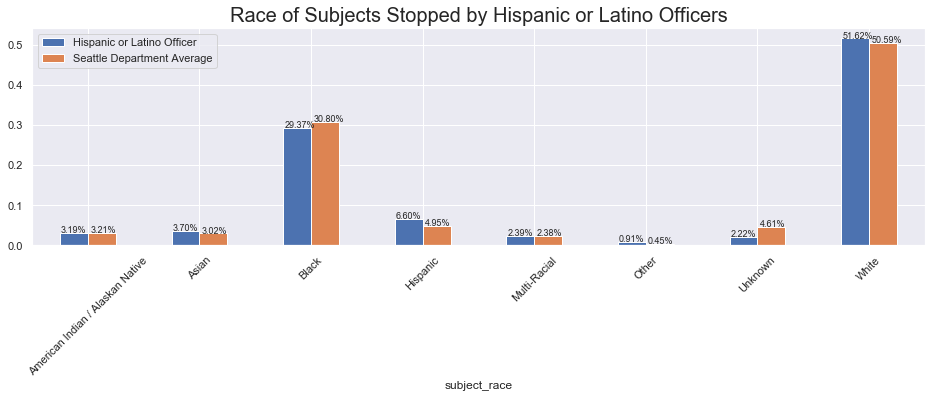

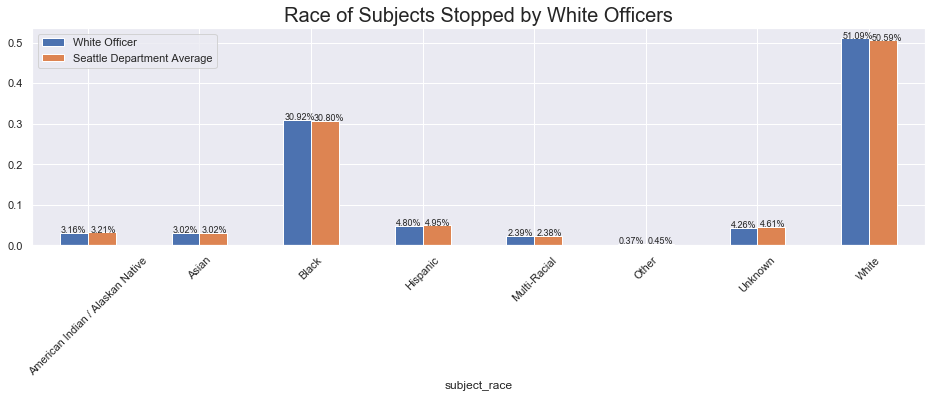

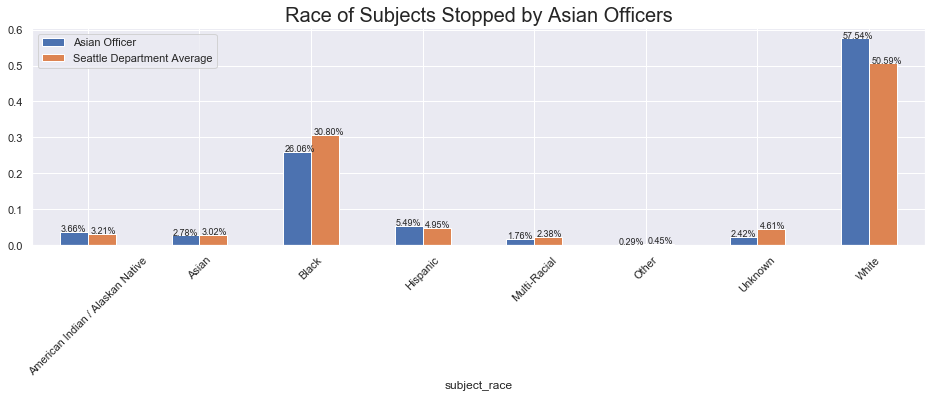

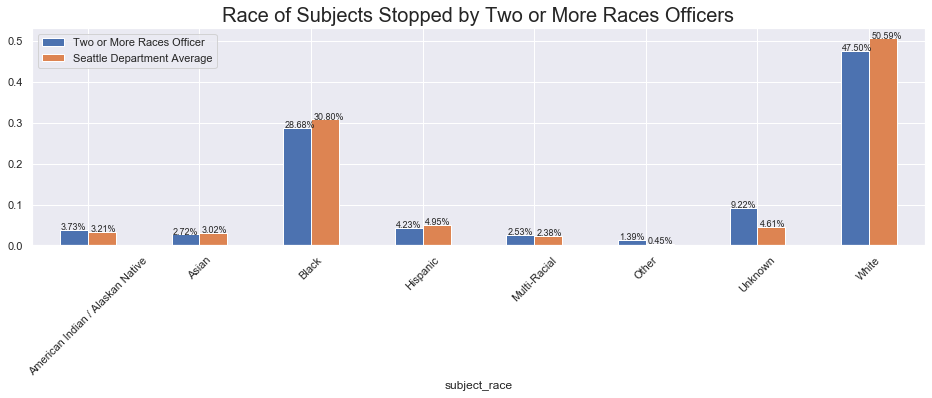

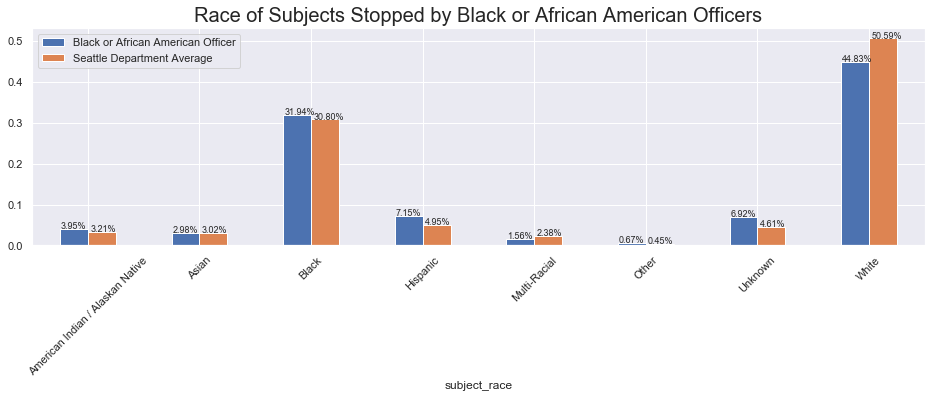

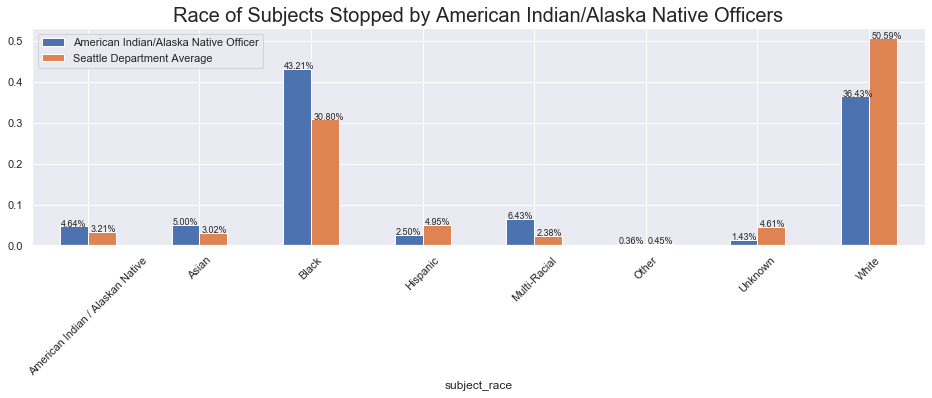

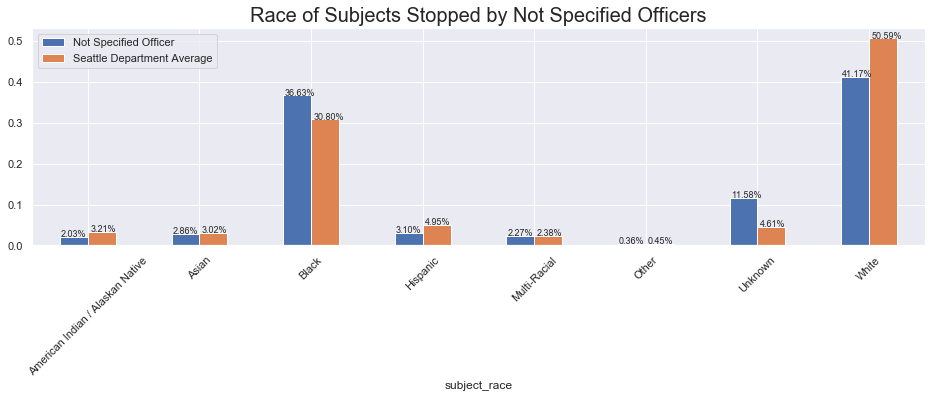

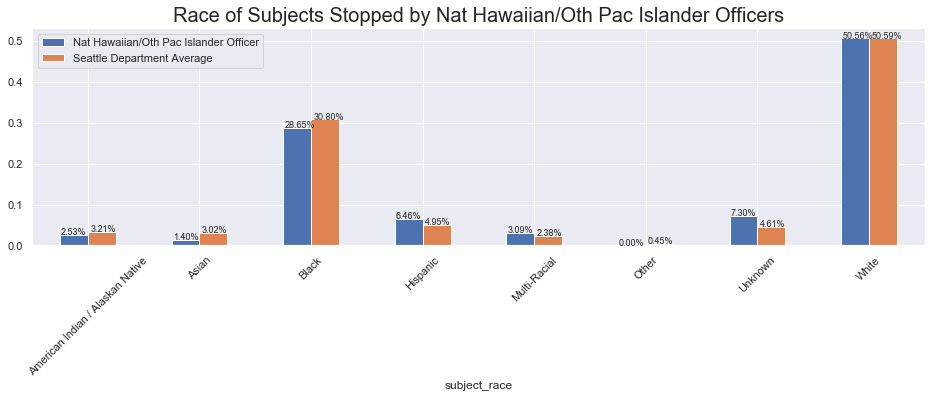

In [8]:
#subset the data
dataframe = data[['officer_race','subject_race','count']]

officer_races = list(data.officer_race.unique()) #obtain a list of all the officer races

df_list = dict() # empty dictionary to hold each filtered dataframe

#create dataframes for each race
for race in officer_races:
    df = dataframe[dataframe.officer_race == race]
    df = df.groupby('subject_race').count()
    df['stop_pct'] = df['count'] / df['count'].sum()
    df.drop(['count', 'officer_race'], axis = 1, inplace = True)
    df_list[race] = df

#create seperate dataframe for department average numbers
tmp = data[['subject_race','count']]
tmp = tmp.groupby('subject_race').count()
tmp['stop_pct'] = tmp['count'] / tmp['count'].sum()
tmp.drop(['count'], axis = 1, inplace = True)
  
    
    
#display the plots
for ttl, df in df_list.items():
    ax = pd.merge(df, tmp, left_index = True, right_index = True).plot(kind = 'bar', figsize = (16,4))
    _=plt.title('Race of Subjects Stopped by {} Officers'.format(ttl), fontsize = 20)
    _=plt.legend(labels = [ttl+' Officer', 'Seattle Department Average'] )
    _=plt.xticks(rotation = 45)
    
    #generate text values above the columns
    for i, v in enumerate(df.stop_pct):
        ax.text(i-.24, v, '{:.2f}%'.format(100*v),fontsize = 9 )
    
    for i, v in enumerate(tmp.stop_pct):
        ax.text(i+.02, v, '{:.2f}%'.format(100*v),fontsize = 9 )

Looking at the resulting graphs, each race largely follow the average of percentage of stops for each race. Asian officers stop White subjects 7% more and Native American officers stop Black subjects 13% more and White subjects 14% less. 

The above chart shows comparisons from the whole dataset, and is the selected officer race vs. the department average. The below graph breaks the data down by month, and you can compare between different races of officers. 

In [9]:

#subset the data
df = data[['officer_race','subject_race','count']]
df = df.loc['2015-04':'2019-04']

other_df = data[['officer_race','subject_race','count']]
other_df = other_df.loc['2015-04':'2019-04']

officer_races = df.officer_race.unique()
subject_races = df.subject_race.unique()
date_range = pd.date_range(start = df.index[0], end = df.index[-1], freq = 'M')

shaped_df = pd.DataFrame()

for month in date_range:
    tmp1 = df.copy()
    tmp2 = other_df.copy()
    tmp1 = tmp1.loc[str(month.year)+'-'+str(month.month)]
    tmp2 = tmp2.loc[str(month.year)+'-'+str(month.month)]
    for officer_race in officer_races:
        tmp3 = tmp1[tmp1.officer_race == officer_race]
        tmp3 = tmp3.groupby('subject_race').count()
        tmp3['stop_pct'] = tmp3['count'] / tmp3['count'].sum()
        tmp3.drop(['count', 'officer_race'], axis = 1, inplace = True)
        tmp3['officer_race'] = officer_race
        tmp3['date'] = str(month.year)+'-'+str(month.strftime('%m'))
        
        tmp4 = tmp2[tmp2['officer_race']!= officer_race]
        tmp4 = tmp4.groupby('subject_race').count()
        tmp4['stop_pct'] = tmp4['count'] / tmp4['count'].sum()
        tmp4.drop(['count', 'officer_race'], axis = 1, inplace = True)
        tmp4['officer_race'] = 'Non-'+officer_race
        tmp4['date'] = str(month.year)+'-'+str(month.strftime('%m'))
        
        tmp4 = tmp3.append(tmp4)
        shaped_df = shaped_df.append(tmp4)

shaped_df = shaped_df.reset_index()
shaped_df = shaped_df.set_index('date')
shaped_df = shaped_df[['officer_race', 'subject_race','stop_pct']]

In [10]:
def modify_doc(doc):
    
    officer_races = [x for x in shaped_df.officer_race.unique() if not x.startswith('Non')]
    o = officer_races[1]
  
    
    #yy= shaped_df[shaped_df.officer_race=='White']
    #tt=shaped_df[shaped_df.officer_race=='Non-White']
    #yy = yy.loc['04-2015']
    
    date_rng = list(np.unique(shaped_df.index))
    dates_dict = {k:v for (k,v) in zip(np.arange(1,len(date_rng)),date_rng)}
    
    
    
    n = dates_dict[1]
    
    
    text_source = ColumnDataSource({'date' : [n]})
     
        
    source = ColumnDataSource( data = shaped_df[shaped_df.officer_race == o].loc[n])

    
    other_source = ColumnDataSource( data = shaped_df[shaped_df.officer_race == 'Non-'+o].loc[n])
    
    #mapper = CategoricalColorMapper(
     #   factors = list(yy.loc[n].subject_race.values),
     #   palette = Spectral8 )

    
    
    hover = HoverTool(tooltips = [('Officer Race', '@officer_race'),
                                  ('Subject Race', '@subject_race'),
                                  ('Percentage of Stops', '@stop_pct'),
                                 ('Date', '@date')])
    
    slider = Slider(start = 1,end = len(dates_dict), value = 1, step = 1, title = 'Year/Month')
    
    menu = Select(options = officer_races  , value = o , title = 'Officer Race')
    
    plot = figure(x_range = list(shaped_df.loc[n].subject_race.unique()), plot_width = 800, tools = [hover],
                 title = 'Race of Subjects Stopped by {} Officers vs. Non-{} Officers during {}'.format(o,o,n))
    
    
    
    plot.vbar(x = dodge('subject_race', -.27, range = plot.x_range), top = 'stop_pct', width = .25, source = source, legend = 'officer_race',
         line_color = 'white', color = '#4e8ef5')
    
    plot.vbar(x = dodge('subject_race', 0.03, range= plot.x_range), top = 'stop_pct', width = .25, source = other_source, legend = 'officer_race',
         line_color = 'white', color = 'lawngreen')
    
    plot.text( x =1.5, y = .65, text = 'date',text_font_size = '100pt',text_color = '#EEEEEE', source = text_source)
    
    plot.xgrid.grid_line_color = None
    plot.y_range.start = 0
    plot.y_range.end = 1
    plot.legend.orientation = 'horizontal'
    def callback(attr, old, new):
        n = slider.value
        o = menu.value
        
        source.data=ColumnDataSource(data = shaped_df[shaped_df.officer_race == o].loc[dates_dict[n]]).data
        other_source.data=ColumnDataSource(data = shaped_df[shaped_df.officer_race == 'Non-'+o].loc[dates_dict[n]]).data
        
        
        new_date = dates_dict[n]
        text_source.data={'date': [new_date]}
        plot.title.text = 'Race of Subjects Stopped by {} Officers vs. Non-{} Officers during {}'.format(o,o,new_date)
        
        
    
    slider.on_change('value', callback)
    menu.on_change('value',callback)

    doc.add_root(column(slider,menu, plot))



In [11]:
show(modify_doc)

The below graph displays these differences over time

In [12]:
officer_races = shaped_df.officer_race.unique()
subject_races = shaped_df.subject_race.unique()

combined_df = pd.DataFrame()

for officer_race in officer_races:
    for subject_race in subject_races:
        l1 = shaped_df[(shaped_df.officer_race== officer_race) & (shaped_df.subject_race ==subject_race)]
        for officer_race_two in officer_races:
            l2 = shaped_df[(shaped_df.officer_race== officer_race_two) & (shaped_df.subject_race ==subject_race)]
            l3 = pd.concat([l1, l2], axis =1)
            l3.columns = ['officer_race','subject_race','officer_stop_pct','other_officer_race', 'o_subject_race','o_stop_pct']
            l3['difference'] = l3['officer_stop_pct'] - l3['o_stop_pct']
            
            combined_df = combined_df.append(l3)   



In [13]:
def modify_doc(doc):
    dates = pd.to_datetime(combined_df.index.unique())
    officer_races = [x for x in combined_df.officer_race.unique() if isinstance(x, str)]
    subject_races = [x for x in combined_df.subject_race.unique() if isinstance(x, str)]
    source = ColumnDataSource(data = {'x' : dates,
                                      'date' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].index,
                                      'y' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].difference, 
                                      'officer_race' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].officer_race, 
                                      'subject_race' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].subject_race,
                                      'officer_stop_pct' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].officer_stop_pct,
                                      'other_officer_race' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].other_officer_race,
                                      'o_subject_race' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].o_subject_race, 
                                      'o_stop_pct' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].o_stop_pct,
                                      'difference' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].difference,
                                     })
    
    ymin, ymax = -.5,.5
    
    hover = HoverTool(tooltips = [('Subject Race', '@subject_race'),
                                  ('First Officer Stop %', '@{officer_stop_pct}{0:.02%}'),
                                  ('Second Officer Stop %', '@{o_stop_pct}{0:.02%}'),
                                  ('Difference', '@{difference}{0:+.02%}'),
                                  ('Date', '@date')])
    

    
    plot = figure(title = 'Difference of Race of Subjects Stopped by {} and Non-{} Officers'.format('White','White'),
                plot_height = 300, plot_width = 850, x_axis_type = 'datetime', y_range = (ymin, ymax), tools = [hover])
    
    plot.yaxis[0].formatter = NumeralTickFormatter(format = '0.0%')
    
    plot.line(x = 'x', y = 'y', source = source, line_width = 2)
    
    
    span = Span(location = 0, line_dash = 'dashed', line_alpha = .5, line_color = 'lawngreen')
    plot.add_layout(span)
    
    plot.circle(x = 'x', y='y', size = 10, fill_color = 'grey', source = source, 
                alpha=.25, line_color = None, 
                hover_fill_color = 'lawngreen', hover_alpha = .9, hover_line_color = 'white')
    
    
    officer_one_select = Select(options = officer_races, 
                                value = 'White', 
                                title = 'First Officer Race' )
    
    officer_two_select = Select(options = officer_races, 
                                value = 'Non-White', 
                                title = 'Second Officer Race' )

    
    subject_select = Select(options = subject_races,
                       value = 'Black', title = 'Subject Race' )
    
    def update_plot(attr, old, new):
        off_one = officer_one_select.value
        off_two = officer_two_select.value
        new_subject = subject_select.value
        
        new_data = {'x' : dates, 
                    'y' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].difference, 
                    'date': combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].index,
                    'officer_race' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].officer_race, 
                    'subject_race' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].subject_race,
                    'officer_stop_pct' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].officer_stop_pct,
                    'other_officer_race' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].other_officer_race,
                    'o_subject_race' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].o_subject_race, 
                    'o_stop_pct' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].o_stop_pct,
                    'difference' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].difference,
                                     }
        source.data = new_data
        
        plot.title.text = 'Difference of Race of Subjects Stopped by {} and Non-{} Officers'.format(off_one,off_two)
        
    
    officer_one_select.on_change('value', update_plot)
    officer_two_select.on_change('value', update_plot)
    subject_select.on_change('value', update_plot)
    
    doc.add_root(column(row(officer_one_select, officer_two_select, subject_select), plot))



In [14]:
show(modify_doc)